In [11]:
import argparse
import yaml
from tqdm import tqdm
import sys
import copy

import pickle

import jax
import jax.numpy as jnp
import optax   

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm


from helpers.data import get_pdf_toy_JAX, read_in_data_JAX

# Initialization and Setup

In [12]:
# TODO: Replace this with Radha's YAML files
mstar = 1
m = 3
n = 7
dist = "thrust"

mult_factor = 2 if dist == "thrust" else 1

alpha_init = 0.118
zero_error_scale = 1 # Fraction of minimum error to set error on 0, default is 1
lr = 0.00100
weight_decay = 0.001
epochs = 50000
batch_size = 320*1
seed = 42
freeze_previous_order = False   # NEW
bogo_init = True
random_batch = True

name = f"{dist}_m{m}_n{n}"
init_from = f"{dist}_m{m-1}_n{n}"

# Seed stuff
np.random.seed(seed)
jax_key = jax.random.PRNGKey(seed)

# Colors
colors = ["red", "violet", "blue"][::-1]
darkcolors = ["darkred", "darkviolet", "darkblue"][::-1]


# Initialize params
params = {
    "alpha" : alpha_init,
    "g_star" : -np.zeros((m+1 - mstar, n+1)),
    "g_coeffs" : -np.zeros((m+1 - mstar, n+1)),
    "thetas" : np.zeros((m+1 - mstar,)) ,
    "thetas_coeffs" : np.zeros((m+1 - mstar,)) ,
    "betas" : 1 * np.ones((m+1 - mstar,)),
    "betas_coeffs" : 1 * np.ones((m+1 - mstar,)),
    "betas_positive" : 0.1 * np.ones((m+1 - mstar,)),
}

beta_limits = [0.0, 25]


factorials = np.ones_like(params["g_star"])
for mi in range(params["g_star"].shape[0]):
    for ni in range(params["g_star"].shape[1]):
        factorials[mi, ni] = 1 / math.factorial(mi + mstar) / math.factorial(ni)




# # For flavor, slightly smarter inits
signs = (-1) * np.power(-1, np.arange(n + 1) % 2)
# params["g_star"][0,0] = -1
params["g_star"][0,1] = -1
params["g_coeffs"][0,1] = 0
params["thetas"][0] = 0.5
if m == 2:
    params["thetas_coeffs"][0] = 0
    params["thetas"][1] = -0
    # params["g_star"][1,2] = 0


# Decent sign initialization
for mi in range(m+1-mstar):
    params["g_star"][mi] *= signs #* factorials[mi]
    params["g_coeffs"][mi] *= signs #* factorials[mi]




In [13]:
# Init from previous file:

def initialize_params(name_, order):

    # Initialize params
    params_ = {
        "alpha" : alpha_init,
        "g_star" : -np.zeros((order+2 - mstar, n+1)),
        "g_coeffs" : -np.zeros((order+2 - mstar, n+1)),
        "thetas" : np.zeros((order+2 - mstar,)) ,
        "thetas_coeffs" : np.zeros((order+2 - mstar,)) ,
        "betas" : 1 * np.ones((order+2 - mstar,)),
        "betas_coeffs" : 1 * np.ones((order+2 - mstar,)),
        "betas_positive" : 0.1 * np.ones((order+2 - mstar,)),
    }

    try:
        with open(f"output_JAX/{name_}_params.pkl", "rb") as f:
            init_params = copy.deepcopy(pickle.load(f))

        g_coeffs_init = init_params["g_coeffs"]
        g_star_init = init_params["g_star"]
        thetas_init = init_params["thetas"]
        thetas_coeffs_init = init_params["thetas_coeffs"]
        betas_init = init_params["betas"]
        betas_coeffs_init = init_params["betas_coeffs"]
        betas_pos_init = init_params["betas_positive"]


        init_m, init_n = g_coeffs_init.shape

        params_["g_coeffs"][:init_m, :init_n] = copy.deepcopy(g_coeffs_init)
        params_["g_star"][:init_m, :init_n] = copy.deepcopy(g_star_init)
        params_["thetas"][:init_m] = copy.deepcopy(thetas_init)
        params_["thetas_coeffs"][:init_m] = copy.deepcopy(thetas_coeffs_init)
        params_["betas"][:init_m] = copy.deepcopy(betas_init) 
        params_["betas_coeffs"][:init_m] = copy.deepcopy(betas_coeffs_init)
        params_["betas_positive"][:init_m] = copy.deepcopy(betas_pos_init)

        return copy.deepcopy(params_)
    
    except:
        print(f"No file" + f"output_JAX/{name_}_params.pkl")
        


params1 = initialize_params(f"{dist}_m1_n{n}", 1)
params2 = initialize_params(f"{dist}_m2_n{n}", 2)


# if init_from:
#     params = init_params(init_from)

# # Save the original params for the purpose of freezing
# original_params = params.copy()

In [14]:
def randomize_params(params):

    scale = 10

    new_params = copy.deepcopy(params)
    shape_m, shape_n = new_params["g_star"].shape

    new_params["g_star"][-1,:] = np.random.normal(loc = new_params["g_star"][-1,:], size = shape_n, scale = scale) 
    new_params["g_coeffs"][-1-mstar,:] = np.random.normal(loc = new_params["g_coeffs"][-1-mstar,:], size = shape_n, scale =  scale )  

    new_params["thetas"][-1] = np.random.uniform(new_params["thetas"][-1]) 
    new_params["thetas_coeffs"][-1-mstar] = np.random.uniform(new_params["thetas_coeffs"][-1-mstar]) 

    new_params["betas"][-1] = 5 * np.random.uniform() 
    new_params["betas_coeffs"][-1-mstar] = 5 * np.random.uniform() 
    new_params["betas_positive"][-1] = 5 * np.random.uniform() 

    return new_params

            # g_coeffs[m-mstar:,:] = 0 # Current order doesn't count

            # # # Choose signs nicely
            # # for ni in range(g_star.shape[1]):

            # #     if n % 2 == 0:
            # #         g_star[:,n] = np.abs(g_star[:,n])
            # #         g_coeffs[:,n] = np.abs(g_coeffs[:,n])
            # #     else:
            # #         g_star[:,n] = -np.abs(g_star[:,n])
            # #         g_coeffs[:,n] = -np.abs(g_coeffs[:,n])


            # thetas = params["thetas"]
            # thetas = np.random.normal(loc = best_params["thetas"], scale = 1 / (np.sqrt(counter) + 1) * scale / 100) 

            # thetas_coeffs = params["thetas_coeffs"]
            # thetas_coeffs = np.random.normal(loc = best_params["thetas_coeffs"], scale = 1 / (np.sqrt(counter) + 1) * scale / 100) 

            # betas = params["betas"]
            # betas = np.random.normal(loc = best_params["betas"], scale = 1 / (np.sqrt(counter) + 1) * scale / 10) 

            # betas_coeffs = params["betas_coeffs"]
            # betas_coeffs = np.random.normal(loc = best_params["betas_coeffs"], scale = 1 / (np.sqrt(counter) + 1) * scale / 10)

            # betas_positive = params["betas_positive"]
            # betas_positive = np.random.normal(loc = best_params["betas_positive"], scale = 1 / (np.sqrt(counter) + 1) * scale / 10)


# Compilation

In [15]:
from utils.function_utils import polynomial, taylor_expand_in_alpha
from utils.distribution_utils import build_q_mstar, log_q, f
from rikabplotlib.plot_utils import newplot

q = build_q_mstar(mstar)

# compile
q_vmap = jax.vmap(q, in_axes=(0,None,None,None,None,None,None,None,None))


# Taylor Expansions
q0_vmap = jax.vmap(taylor_expand_in_alpha(q, 0), in_axes=(0,None,None,None,None,None,None,None,None))
q1_vmap = jax.vmap(taylor_expand_in_alpha(q, 1), in_axes=(0,None,None,None,None,None,None,None,None))
q2_vmap = jax.vmap(taylor_expand_in_alpha(q, 2), in_axes=(0,None,None,None,None,None,None,None,None))
q3_vmap = jax.vmap(taylor_expand_in_alpha(q, 3), in_axes=(0,None,None,None,None,None,None,None,None))
# ... Add more if necessary, can loop if we really have to

qm_vmap = [q0_vmap, q1_vmap, q2_vmap, q3_vmap]

# ##### Second vmap over alpha #####
q_vmap2 = jax.vmap(q_vmap, in_axes = (None, 0, None, None, None, None, None, None, None))
qm_vmap2 = []
for qi in qm_vmap:
    qi_vmap2 = jax.vmap(qi, in_axes = (None, 0, None, None, None, None, None, None, None))
    qm_vmap2.append(qi_vmap2)



# Select the Taylor Expansion Function
CHOSEN_Q_VMAP = qm_vmap[m]
CHOSEN_Q_VMAP2 = qm_vmap2[m]


# Helper functions
def Q_ANSATZ(ts, alpha, params):
    return q_vmap(ts, alpha, params["g_star"], params["g_coeffs"], params["thetas"], params["thetas_coeffs"], params["betas"], params["betas_coeffs"], params["betas_positive"])

def QM_ANSATZ(ts, alphas, params):
    return CHOSEN_Q_VMAP(ts, alphas, params["g_star"], params["g_coeffs"], params["thetas"], params["thetas_coeffs"], params["betas"], params["betas_coeffs"], params["betas_positive"])


def Q_ANSATZ_alpha(ts, params):
    return q_vmap(ts, params["alpha"], params["g_star"], params["g_coeffs"], params["thetas"], params["thetas_coeffs"], params["betas"], params["betas_coeffs"], params["betas_positive"])

def QM_ANSATZ_alpha(ts, params):
    return CHOSEN_Q_VMAP(ts, params["alpha"], params["g_star"], params["g_coeffs"], params["thetas"], params["thetas_coeffs"], params["betas"], params["betas_coeffs"], params["betas_positive"])



# Data Setup

Opal Data from https://www.hepdata.net/record/ins440721?version=1&table=Table%203

ALEPH Data from https://www.hepdata.net/record/ins636645?version=1&table=Table%2054

In [16]:

LEP = {
    "THRUST": 1-np.array([
        0.585,0.595,0.605,0.615,0.625,0.635,0.645,0.655,0.665,0.675,
        0.685,0.695,0.705,0.715,0.725,0.735,0.745,0.755,0.765,0.775,
        0.785,0.795,0.805,0.815,0.825,0.835,0.845,0.855,0.865,0.875,
        0.885,0.895,0.905,0.915,0.925,0.935,0.945,0.955,0.965,0.975,
        0.985,0.995
    ]),
    "THRUST_LOW": 1-np.array([
        0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,
        0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,
        0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,
        0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,
        0.98,0.99
    ]),
    "THRUST_HIGH": 1-np.array([
        0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,
        0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,
        0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,
        0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,
        0.99,1.0
    ]),
    "DSIG": np.array([
        0.00115,0.00229,0.0035,0.00839,0.01283,0.02148,0.0433,0.06556,0.10284,0.12575,
        0.16396,0.18416,0.21424,0.24814,0.29427,0.34347,0.36536,0.43088,0.46923,0.54584,
        0.59942,0.66087,0.768,0.857,0.98079,1.1127,1.27035,1.43939,1.63938,1.93459,
        2.23002,2.63072,3.06214,3.70212,4.54709,5.64464,7.27722,9.62952,13.60396,18.56511,
        12.88646,1.31186
    ]),
    "stat_plus": np.array([
        0.00034,0.0005,0.00061,0.00096,0.00116,0.00152,0.00223,0.00267,0.00334,0.00366,
        0.00418,0.00449,0.00466,0.00511,0.00567,0.00609,0.00614,0.00691,0.00709,0.0079,
        0.00814,0.00856,0.00928,0.00974,0.0106,0.01125,0.01209,0.01339,0.01372,0.01504,
        0.01641,0.01811,0.01892,0.02073,0.02343,0.02568,0.02929,0.03385,0.04085,0.04923,
        0.03872,0.00986
    ]),
    "stat_minus": np.array([
        -0.00034,-0.0005,-0.00061,-0.00096,-0.00116,-0.00152,-0.00223,-0.00267,-0.00334,-0.00366,
        -0.00418,-0.00449,-0.00466,-0.00511,-0.00567,-0.00609,-0.00614,-0.00691,-0.00709,-0.0079,
        -0.00814,-0.00856,-0.00928,-0.00974,-0.0106,-0.01125,-0.01209,-0.01339,-0.01372,-0.01504,
        -0.01641,-0.01811,-0.01892,-0.02073,-0.02343,-0.02568,-0.02929,-0.03385,-0.04085,-0.04923,
        -0.03872,-0.00986
    ]),
    "sys1_plus": np.array([
        0.00052,0.00093,0.00087,0.00077,0.00082,0.00095,0.00496,0.00273,0.00353,0.00297,
        0.00474,0.00871,0.00455,0.01328,0.00573,0.00801,0.00707,0.00868,0.01309,0.00687,
        0.00809,0.02434,0.0152,0.01211,0.01281,0.00939,0.00874,0.00965,0.02383,0.02559,
        0.0291,0.01555,0.03499,0.0235,0.03555,0.03708,0.0454,0.07026,0.07561,0.08476,
        0.22928,0.19542
    ]),
    "sys1_minus": np.array([
        -0.00052,-0.00093,-0.00087,-0.00077,-0.00082,-0.00095,-0.00496,-0.00273,-0.00353,-0.00297,
        -0.00474,-0.00871,-0.00455,-0.01328,-0.00573,-0.00801,-0.00707,-0.00868,-0.01309,-0.00687,
        -0.00809,-0.02434,-0.0152,-0.01211,-0.01281,-0.00939,-0.00874,-0.00965,-0.02383,-0.02559,
        -0.0291,-0.01555,-0.03499,-0.0235,-0.03555,-0.03708,-0.0454,-0.07026,-0.07561,-0.08476,
        -0.22928,-0.19542
    ]),
    "sys2_plus": np.array([
        0.00033,0.00065,0.001,0.0017,0.0026,0.00436,0.00307,0.00464,0.00728,0.00984,
        0.01283,0.01441,0.01503,0.01741,0.02065,0.01874,0.01993,0.0235,0.01728,0.0201,
        0.02208,0.02607,0.0303,0.03381,0.04685,0.05316,0.06069,0.052,0.05922,0.06989,
        0.06846,0.08076,0.09401,0.07685,0.09439,0.11718,0.11117,0.1471,0.20781,0.68299,
        0.47408,0.04826
    ]),
    "sys2_minus": np.array([
        -0.00033,-0.00065,-0.001,-0.0017,-0.0026,-0.00436,-0.00307,-0.00464,-0.00728,-0.00984,
        -0.01283,-0.01441,-0.01503,-0.01741,-0.02065,-0.01874,-0.01993,-0.0235,-0.01728,-0.0201,
        -0.02208,-0.02607,-0.0303,-0.03381,-0.04685,-0.05316,-0.06069,-0.052,-0.05922,-0.06989,
        -0.06846,-0.08076,-0.09401,-0.07685,-0.09439,-0.11718,-0.11117,-0.1471,-0.20781,-0.68299,
        -0.47408,-0.04826
    ]),
}


OPAL = {
    "THRUST": 1-np.array([0.74,0.815,0.865,0.895,0.92,0.94,0.955,0.965,0.975,0.985,0.995]),
    "THRUST_LOW": 1-np.array([0.7,0.78,0.85,0.88,0.91,0.93,0.95,0.96,0.97,0.98,0.99]),
    "THRUST_HIGH": 1-np.array([0.78,0.85,0.88,0.91,0.93,0.95,0.96,0.97,0.98,0.99,1.0]),
    "DSIG": np.array([0.14,0.93,1.02,3.1,3.56,3.92,6.5,10.1,18.1,22.1,8.6]),
    "stat_plus": np.array([0.12,0.24,0.39,0.64,0.82,0.84,1.5,1.9,2.5,2.9,1.7]),
    "stat_minus": np.array([-0.12,-0.24,-0.39,-0.64,-0.82,-0.84,-1.5,-1.9,-2.5,-2.9,-1.7]),
    "sys_plus": np.array([0.47,0.47,0.61,0.59,0.81,1.29,1.4,1.6,2.6,2.6,2.6]),
    "sys_minus": np.array([-0.47,-0.47,-0.61,-0.59,-0.81,-1.29,-1.4,-1.6,-2.6,-2.6,-2.6]),
}


def add_total_error_columns(d,):

    running_err2 = d["stat_plus"]**2
    for key in d.keys():
        if "sys" in key and "plus" in key:
            running_err2 += d[key]**2

    d["total_err"] = np.sqrt(running_err2)

    return d

LEP = add_total_error_columns(LEP)
OPAL = add_total_error_columns(OPAL)

-0.8688103847684082


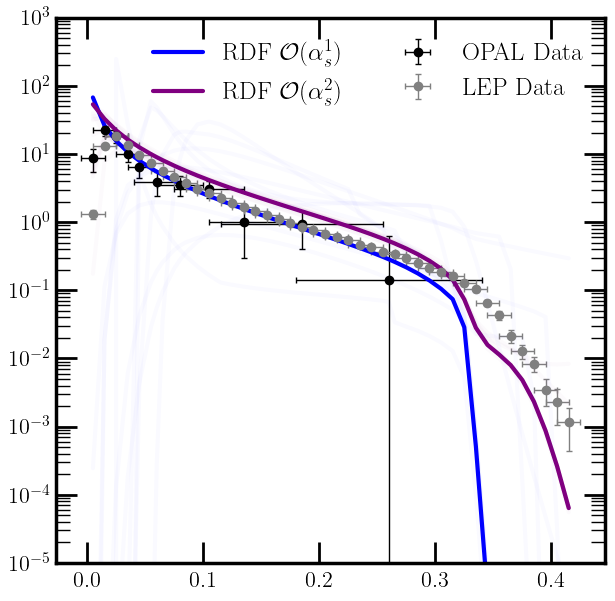

In [17]:
if dist == "thrust":

    xOPAL_bin_centers = OPAL["THRUST"]
    xLEP_bin_centers = LEP["THRUST"]
    tOPAL_bin_centers = np.log(1/(2 * xOPAL_bin_centers))
    tLEP_bin_centers = np.log(1/(2 * xLEP_bin_centers))
    

    xlow =  OPAL["THRUST_LOW"]
    xhigh = OPAL["THRUST_HIGH"]
    xOPAL_bin_widths = -(xhigh-xlow) # minus because 1-T gives a sign

    xlow =  LEP["THRUST_LOW"]
    xhigh = LEP["THRUST_HIGH"]
    xLEP_bin_widths = -(xhigh-xlow) # minus because 1-T gives a sign

    yOPALs = OPAL["DSIG"]
    yLEPs = LEP["DSIG"]

    yOPAL_errs = OPAL["total_err"]
    yLEP_errs = LEP["total_err"]


    x_bin_centers = np.sort(np.concatenate([xOPAL_bin_centers, xLEP_bin_centers]))
    t_bin_centers =(np.log(1/(2 * x_bin_centers)))
    ys = np.concatenate([yOPALs, yLEPs])
    y_errs = np.concatenate([yOPAL_errs, yLEP_errs])



# Plot data


fig, ax = newplot("full")
plt.errorbar(xOPAL_bin_centers, yOPALs, yerr=yOPAL_errs, xerr = xOPAL_bin_widths, fmt='o', color='black', lw=1, capsize=2, label = "OPAL Data")
plt.errorbar(xLEP_bin_centers, yLEPs, yerr=yLEP_errs, xerr = xLEP_bin_widths, fmt='o', color='grey', lw=1, capsize=2, label = "LEP Data")



q_vals1 = Q_ANSATZ(t_bin_centers, alpha_init, params1) / x_bin_centers * mult_factor
q_vals2 = Q_ANSATZ(t_bin_centers, alpha_init, params2) / x_bin_centers * mult_factor

plt.plot(x_bin_centers, q_vals1, color = "blue", label = r"RDF $\mathcal{O}(\alpha_s^1)$")
plt.plot(x_bin_centers, q_vals2, color = "purple", label = r"RDF $\mathcal{O}(\alpha_s^2)$")



for i in range(10):
    q_vals1 = Q_ANSATZ(t_bin_centers, alpha_init, randomize_params(params1)) / x_bin_centers * mult_factor

    plt.plot(x_bin_centers, q_vals1, color = "blue", alpha = 0.02)


for i in range(10):
    q_vals2 = Q_ANSATZ(t_bin_centers, alpha_init, randomize_params(params2)) / x_bin_centers * mult_factor
    plt.plot(x_bin_centers, q_vals2, color = "purple", alpha = 0.02)


# plt.plot(x_bin_centers, q_taylor_vals)

print(np.trapz(Q_ANSATZ(t_bin_centers, alpha_init, params2), t_bin_centers))

plt.ylim(1e-5, 1e3)

plt.legend(ncol = 2)

plt.yscale("log")





# Loss

In [18]:
# Weighted MSE
@jax.jit
def loss_function(params, alpha, ys, yerrs):



    y_preds = jnp.nan_to_num(QM_ANSATZ(tLEP_bin_centers, alpha, params)) / xLEP_bin_centers * mult_factor
    y_errs_rescaled = yLEP_errs #/ mean_errors

    return jnp.mean(jnp.nan_to_num((y_preds - ys)**2 /(y_errs_rescaled**2 ))) / 2

@jax.jit
def loss_function_alpha(params, ys, yerrs):



    y_preds = jnp.nan_to_num(Q_ANSATZ_alpha(tLEP_bin_centers, params)) / xLEP_bin_centers * mult_factor
    y_errs_rescaled = yLEP_errs #/ mean_errors

    return jnp.mean(jnp.nan_to_num((y_preds - ys)**2 /(y_errs_rescaled**2 ))) / 2



print("Initial Loss: ", loss_function_alpha(params1, yLEPs, yLEP_errs))


Initial Loss:  1298.6938


In [23]:
def projector(params, original_params):


    # Get the signs right
    g_star = params["g_star"]
    g_coeffs = params["g_coeffs"]
    thetas = params["thetas"]
    thetas_coeffs = params["thetas_coeffs"]
    betas = params["betas"]
    betas_coeffs = params["betas_coeffs"]
    betas_pos = params["betas_positive"]


    g_star = g_star.at[:, -1].set(-jnp.abs(g_star[:, -1]))
    g_coeffs = g_coeffs.at[:, -1].set(-jnp.abs(g_coeffs[:, -1]))

    # Clip beta
    betas = jnp.clip(betas, beta_limits[0], beta_limits[1])
    betas_coeffs = jnp.clip(betas_coeffs, beta_limits[0], beta_limits[1])
    betas_pos = jnp.clip(betas_pos, beta_limits[0], beta_limits[1])

    # betas = beta_limits[0] + jnp.ones_like(betas) * epoch * (beta_limits[1] - beta_limits[0])
    # betas_coeffs = beta_limits[0] + jnp.ones_like(betas_coeffs) * epoch * (beta_limits[1] - beta_limits[0])

    g_coeffs = g_coeffs.at[m-mstar:,:].set(0)  # Current order doesn't count
    thetas_coeffs = thetas_coeffs.at[m-mstar:,].set(-1)  # Current order doesn't count



    # Restore the original parameters 
    g_coeffs_init = original_params["g_coeffs"]
    g_star_init = original_params["g_star"]
    thetas_init = original_params["thetas"]
    thetas_coeffs_init = original_params["thetas_coeffs"]
    betas_init = original_params["betas"]
    betas_coeffs_init = original_params["betas_coeffs"]
    betas_pos_init = original_params["betas_positive"]


    g_star = g_star.at[:-1].set(g_star_init[:-1])
    g_coeffs = g_coeffs.at[:-1-mstar].set(g_coeffs_init[:-1-mstar])
    thetas = thetas.at[:-1].set(thetas_init[:-1])
    thetas_coeffs = thetas_coeffs.at[:-1-mstar].set(thetas_coeffs_init[:-1-mstar])
    betas = betas.at[:-1].set(betas_init[:-1])
    betas_coeffs = betas_coeffs.at[:-1-mstar].set(betas_coeffs_init[:-1-mstar])
    betas_pos = betas_pos.at[:-1].set(betas_pos_init[:-1])



    params["g_star"] = g_star
    params["g_coeffs"] = g_coeffs
    params["thetas"] = thetas
    params["thetas_coeffs"] = thetas_coeffs
    params["betas"] = betas
    params["betas_coeffs"] = betas_coeffs
    params["betas_positive"] = betas_pos

    return params

  0%|          | 0/50000 [00:00<?, ?it/s]

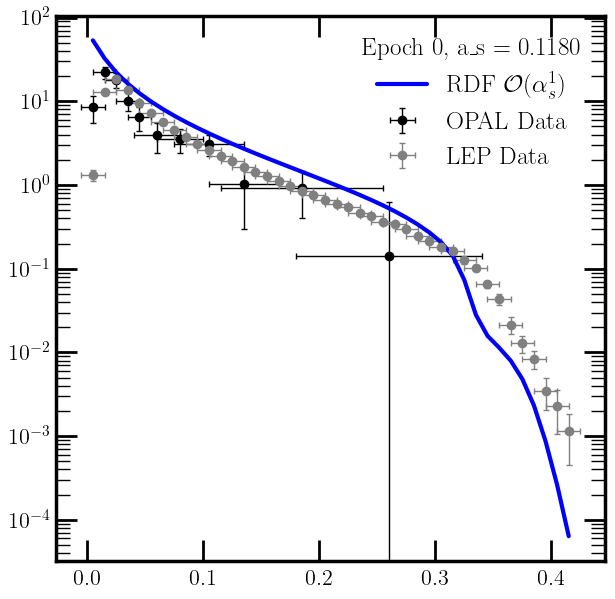

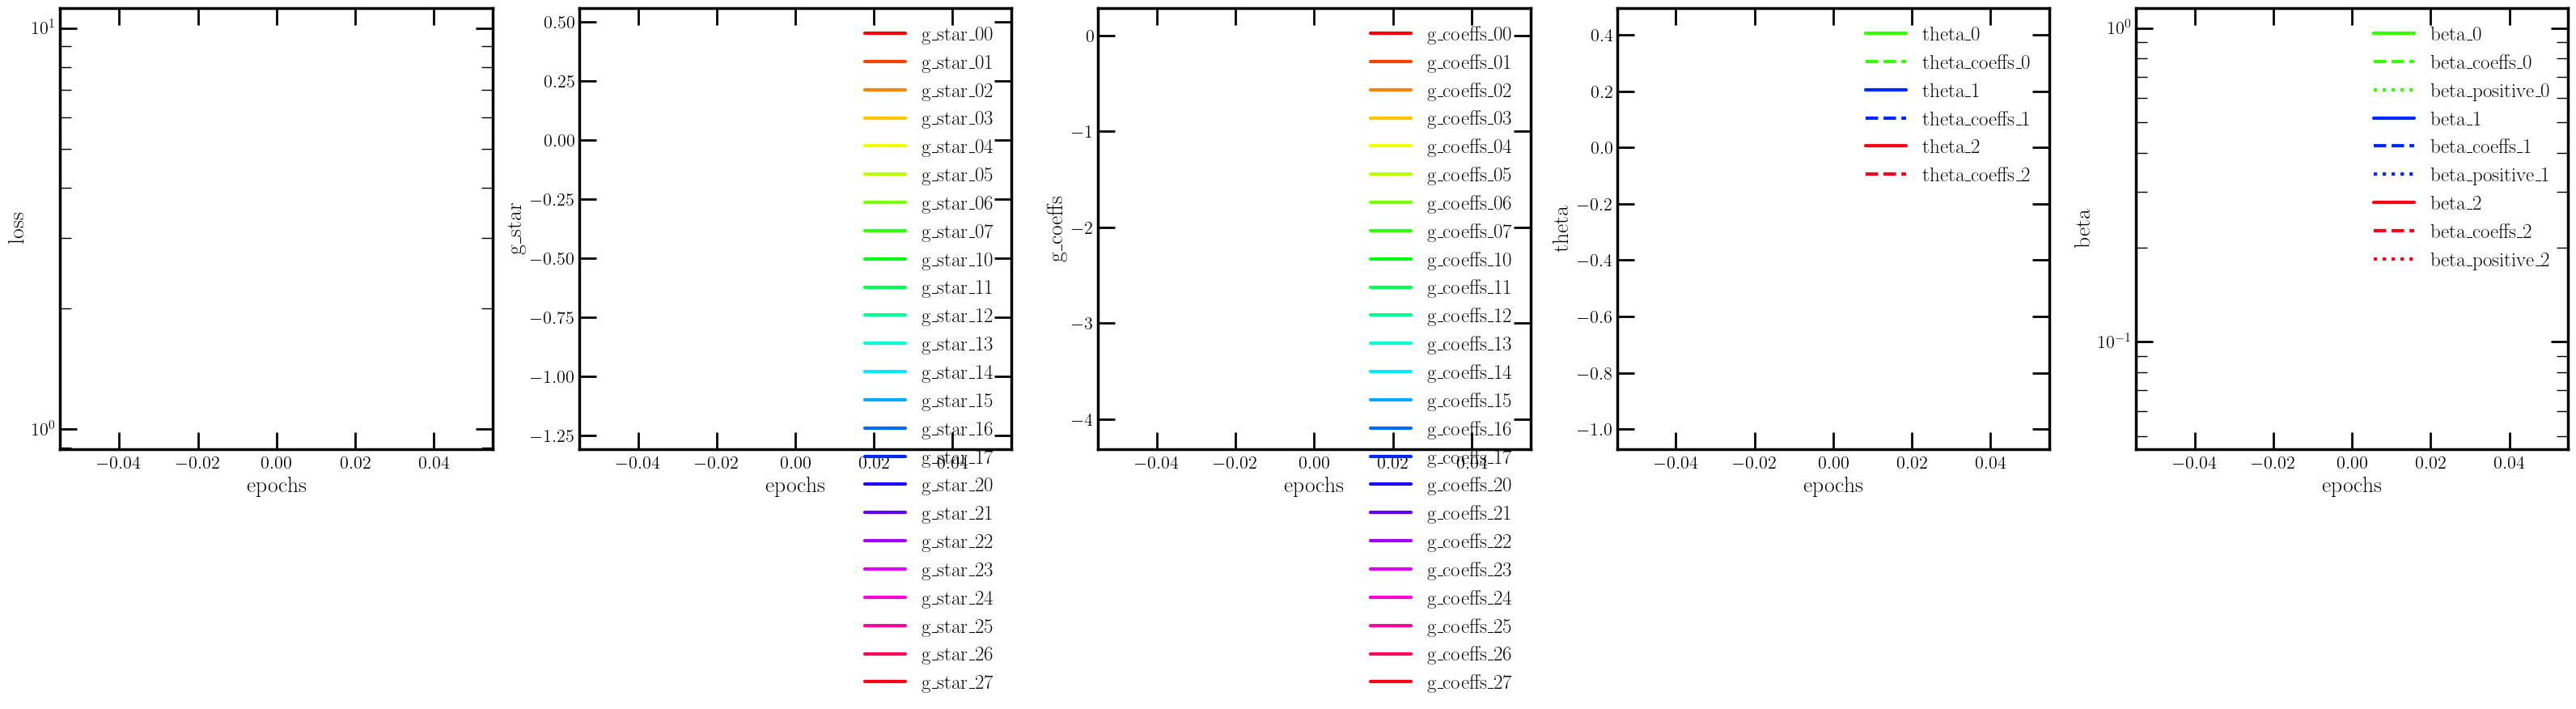

  0%|          | 0/50000 [00:14<?, ?it/s]


ValueError: Incompatible shapes for broadcasting: (2,) and requested shape (1,)

In [ ]:
params = params
original_params = copy.deepcopy(params1)


# Initialize Optimizer
opt = optax.adamw(lr  , weight_decay= weight_decay)
opt_state = opt.init(params)

# Initialize logs
losses = []
params_log = []
params_log.append(params)
g_coeffs_log = [params["g_coeffs"]]
g_star_log = [params["g_star"]]
thetas_log = [params["thetas"]]
betas_log = [params["betas"]]
thetas_c_log = [params["thetas_coeffs"]]
betas_c_log = [params["betas_coeffs"]]
betas_p_log = [params["betas_positive"]]


# @jax.jit
def train_step(epoch, params, opt_state, random_key):
    
    # Boilerplate, in case we need random numbers
    key, subkey = jax.random.split(random_key)


    y_batch = yLEPs
    yerrs_batch = yLEP_errs

    # Get the gradients
    loss, grad_loss = jax.value_and_grad(loss_function_alpha)(params, y_batch, yerrs_batch)


    # Jax Grad Descent stuff
    updates, opt_state = opt.update(grad_loss, opt_state, params=params)
    params = optax.apply_updates(params, updates)

    

    # Save the random key for the seed for the next epoch
    return params, opt_state, loss, subkey

# Loop
epochs_tqdm = tqdm(range(epochs))
for epoch in epochs_tqdm:



    if epoch % 1000 == 0:
        fig, ax = newplot("full")
        plt.errorbar(xOPAL_bin_centers, yOPALs, yerr=yOPAL_errs, xerr = xOPAL_bin_widths, fmt='o', color='black', lw=1, capsize=2, label = "OPAL Data")
        plt.errorbar(xLEP_bin_centers, yLEPs, yerr=yLEP_errs, xerr = xLEP_bin_widths, fmt='o', color='grey', lw=1, capsize=2, label = "LEP Data")

        q_vals = Q_ANSATZ_alpha(tLEP_bin_centers, params) / xLEP_bin_centers * mult_factor


        # q_vals1 = Q_ANSATZ(t_bin_centers, alpha_init, params1) / x_bin_centers * mult_factor
        # q_vals2 = Q_ANSATZ(t_bin_centers, alpha_init, params2) / x_bin_centers * mult_factor

        plt.plot(xLEP_bin_centers, q_vals, color = "blue", label = r"RDF $\mathcal{O}(\alpha_s^1)$")
        # plt.plot(x_bin_centers, q_vals2, color = "purple", label = r"RDF $\mathcal{O}(\alpha_s^2)$")



        # for i in range(50):
        #     q_vals1 = Q_ANSATZ(t_bin_centers, alpha_init, randomize_params(params)) / x_bin_centers * mult_factor
        #     plt.plot(x_bin_centers, q_vals, color = "blue", alpha = 0.1)

        a = params["alpha"]
        plt.legend(title = f"Epoch {epoch}, a_s = { a : .4f}")




    #     ax[0].set_xscale("log")
    #     ax[1].set_yscale("log")

    #     ax[0].set_ylim(-0.1, 1e0)
    #     ax[1].set_ylim(1e-9, 1e6)

    #     ax[0].set_xlabel(r"$t$")
    #     ax[1].set_xlabel(r"$x$")


    #     # plt.xlim(0, 1)
        plt.yscale("log")
        plt.show()


        fig, ax = newplot("full", width = 8 * 5, subplot_array=(1, 5))

        losses_ = np.array(losses)
        g_star_log_ = np.array(g_star_log)
        g_coeffs_log_ = np.array(g_coeffs_log)
        thetas_log_ = np.array(thetas_log)
        betas_log_ = np.array(betas_log)
        thetas_c_log_ = np.array(thetas_c_log)
        betas_c_log_ = np.array(betas_c_log)
        betas_p_log_ = np.array(betas_p_log)


        color = iter(
            cm.hsv(np.linspace(0, 1, g_coeffs_log_.shape[1] * g_coeffs_log_.shape[2]))
        )


        ax[0].plot(losses_)
        ax[0].set_yscale("log")

        for mi in range(g_star_log_.shape[1]):


            for ni in range(g_star_log_.shape[2]):

                c = next(color)

                ax[1].plot(g_star_log_[:,mi,ni], color = c, label = f"g_star_{mi}{ni}")
                ax[2].plot(g_coeffs_log_[:,mi,ni], color = c, label = f"g_coeffs_{mi}{ni}")


            ax[3].plot(thetas_log_[:,mi], label = f"theta_{mi}", color = c)
            ax[4].plot(betas_log_[:,mi], label = f"beta_{mi}", color = c)

            ax[3].plot(thetas_c_log_[:,mi], label = f"theta_coeffs_{mi}", color = c, ls = "--")
            ax[4].plot(betas_c_log_[:,mi], label = f"beta_coeffs_{mi}", color = c, ls = "--")

            ax[4].plot(betas_p_log_[:,mi], label = f"beta_positive_{mi}", ls = ":", color = c)

        ax[0].set_ylabel("loss")
        ax[0].set_xlabel("epochs")

        ax[1].legend()
        ax[1].set_ylabel("g_star")
        ax[1].set_xlabel("epochs")

        ax[2].legend()
        ax[2].set_ylabel("g_coeffs")
        ax[2].set_xlabel("epochs")

        ax[3].legend()
        ax[3].set_ylabel("theta")
        ax[3].set_xlabel("epochs")


        ax[4].legend()
        ax[4].set_ylabel("beta")
        ax[4].set_xlabel("epochs")
        plt.yscale("log")
        plt.show()

    # Train Step
    params, opt_state, loss, jax_key = train_step(epoch, params, opt_state, jax_key)


    # Project the params to make them physical
    params = projector(params, original_params)
    # print(params)

    losses.append(loss)
    g_star_log.append(params['g_star'])
    g_coeffs_log.append(params['g_coeffs'])
    thetas_log.append(params['thetas'])
    betas_log.append(params["betas"])
    thetas_c_log.append(params["thetas_coeffs"])
    betas_c_log.append(params["betas_coeffs"])
    betas_p_log.append(params["betas_positive"])
    params_log.append(params)


    epochs_tqdm.set_description(f"{losses[-1].item() : .4e}")
    # print(g_coeffs_log[-1])
    # print(g_star_log[-1])
    # print(thetas_log[-1])

